In [101]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from DataSeparator import *

## Low vs high injection load: effect on vision

In [131]:
class Vision:
    
    def __init__(self, doctor):
        self.doctor = doctor
        self.obj = DataSeparator("all", self.doctor)
        self.pdf_list = self.obj.patient_dataframes()

    def first_year_stats(self):
        one_dfs = list(map(self.one_year_cutoff, self.pdf_list))
        first_year_injs = [len(pdf) for pdf in one_dfs]
        return round(np.mean(first_year_injs),2)
        
    def one_year_cutoff(self, pdf):
        pdf.reset_index(drop=True, inplace=True)
        initiation = pdf.admission_date[0]
        delta = datetime.timedelta(days=365)
        cutoff = initiation + delta
        return pdf[pdf.admission_date <= cutoff]
    
    def two_groups(self):
        threshold = self.first_year_stats()
        low, high = [], []
        for pdf in self.pdf_list:
            if len(self.one_year_cutoff(pdf)) < threshold:
                low.append(pdf)
            else: high.append(pdf)
        return low, high
    
    def ovc(self, df_list):
        ovc_list = []
        for df in df_list:
            df.sort_values(by=['admission_date'], inplace=True)
            df.dropna(subset=['visual_acuity'], inplace=True)
            visions = df['visual_acuity'].to_list()
            ovc_list.append(visions[-1] - visions[0])
        return ovc_list
    
    def test_difference(self):
        low, high = self.two_groups()
        ovc_low, ovc_high = self.ovc(low), self.ovc(high)
        t, p = stats.ttest_ind(ovc_low, ovc_high)
        return p
    
    def regression_data(self):
        injs_list, ovc_list = [], []
        for pdf in self.pdf_list:
            injs = len(self.one_year_cutoff(pdf))
            ovc = self.ovc([pdf])[0]
            injs_list.append(injs), ovc_list.append(ovc)
        return injs_list, ovc_list

In [132]:
thing = Vision("/devchau_bor.csv")
thing.test_difference()

0.0019332386020071077

In [127]:
low, high = thing.two_groups()
ovc_low, ovc_high = thing.ovc(low), thing.ovc(high)
ovc_list = ovc_low + ovc_high
np.max(ovc_low), np.max(ovc_high)

(19.0, 56.0)

Coefficients: 
 [0.90168878]
Coefficient of determination: 0.07


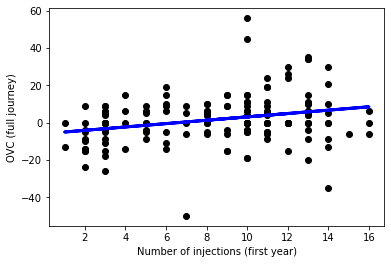

In [130]:
# get the regression date
injs, ovc = thing.regression_data()
injs, ovc = np.array(injs), np.array(ovc)
injs = injs.reshape(-1, 1)

# create linear regression object
regr = linear_model.LinearRegression()

# train the model
regr.fit(injs, ovc)

# make predictions
pred_ovc = regr.predict(injs)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(ovc, pred_ovc))

# plot outputs
plt.scatter(injs, ovc,  color='black')
plt.plot(injs, pred_ovc, color='blue', linewidth=3)
plt.xlabel("Number of injections (first year)")
plt.ylabel("OVC (full journey)")
plt.show()

## Injections by year

In [146]:
class Interval:
    
    def __init__(self, doctor):
        self.doctor = doctor
        self.obj = DataSeparator("all", self.doctor)
        self.pdf_list = self.obj.patient_dataframes()
    
    def year_cutoff(self, pdf, year):
        pdf.reset_index(drop=True, inplace=True)
        initiation = pdf.admission_date[0]
        delta = datetime.timedelta(days=365*year)
        upper = initiation + delta
        lower = initiation + datetime.timedelta(days=365*(year-1))
        return pdf[(pdf.admission_date <= upper) & (pdf.admission_date >= lower)]
    
    def injection_list(self, year):
        inj_list = []
        for pdf in self.pdf_list:
            pdf = self.year_cutoff(pdf, year)
            if len(pdf) != 0: inj_list.append(len(pdf))
        return inj_list

In [157]:
thing = Interval("/ericmayer.csv")
inj_list = thing.injection_list(3)
np.mean(inj_list), np.median(inj_list), np.min(inj_list), np.max(inj_list)

(6.711538461538462, 6.0, 1, 17)